# Harshit Agrawal, Student# 598318

$$\pagebreak$$

# Optimization of Fully Convolutional Neural Networks

In this exercise, you will use the the model explained in the demonstration and apply some optimization techniques for empirical risk minimization by:

1. Tuning the bias initializations using grid search
2. Implementing the model of momentum and Adam to accelerate learning

Remember the model structure:

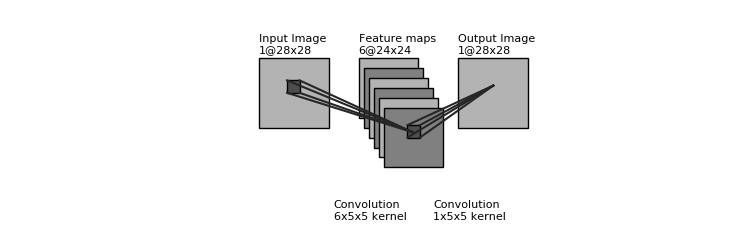

In [1]:
from IPython.display import Image
Image(filename='images/convnetStructureforAssignment.png',height=800,width=800)

We will begin the assignment by importing necessary python libraries:

In [2]:
import six.moves.cPickle as pickle
import matplotlib.pyplot as plt
import gzip
import os, sys
import numpy as np 
import theano
import theano.tensor as T
from theano.tensor.nnet import conv2d
from exercise_helper import load_data, conv_layer
print('***** Import complete *****')

***** Import complete *****


**Mini-Batch Gradient Descent** was already implemented in both this week and last week's demos. It is also used as an optimization technique. It updates weights incrementally after each iteration and calculates the cost over mini batches. In the below function, *updates* variable shows the update operation for each parameter (weights and biases) based on the calculated cost with the learning rate. 
You can use this model as a hint for the rest of the homework.

In [3]:
def gradient_updates_sgd(cost, params, learning_rate):
    # Function to return an update list for the parameters to be updated
    
    # Inputs:
    # cost: MSE cost Theano variable
    # params :  parameters coming from hidden and output layers
    # learning rate: learning rate defined as hyperparameter
    
    # Outputs:
    # updates : updates to be made and to be defined in the train_model function. 
    updates = []
    # just gradient descent on cost
    for param in params:
        # use append function to make a list for which Theano variables will be
        # updated with which value
        updates.append((param, param - learning_rate*T.grad(cost, param)))
    return updates

### 1. Parameter Initialization
Now we will create a function *run_convnet()* to run the experiments. The inside of the function is a little bit different than the demo. First, there is two different ways to initialize the output layer bias outside the *conv_layer()* operation. **Note that you have to write the non-shared bias initialization by yourself. You can return the demo for more explanation of the shared and non-shared bias initialization types. ** Secondly, the function updates weights and biases based on the *momentum_type* parameter. Check the *gradient_updates_sgd* code above to get a hint for other parameter update functions.
In the non-shared initialization mode, the biases will start from the same value; however now we will have 28x28 matrix, so there will be a different bias for every neuron in the output layer.

In [20]:
def run_convnet(learning_rate, num_epochs, 
                train_set_x,
                num_filters, batch_size, 
                momentum_type, bias_type, bias_init=None):
    # Function to create the convolutional neural network, train and
    # evaluate it. 
    
    # Inputs:
    # learning_rate - Learning rate for Stochastic Gradient Descent
    # num_epochs - Number of training epochs
    # train_set_x - training set
    # num_filters - Number of channels for each convolution layer
    #               for e.g. 2 layers - [20, 50]. 
    #.              layer1 = 20, layer2 = 50
    # batch_size - Mini-batch size to be used
    # momentum_type - Parameter update algorithm to be used
    # bias type - bias initialization type to be used 
    #                shared or non-shared
    # bias_init - initial value for bias
    
    # Outputs:
    # Training MSE for each iteration
    
    # random seed to initialize the pseudo-random number generator.
    rng = np.random.RandomState(23455)

    # compute number of minibatches for training and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
    n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

    # get the dimensions for input images
    import math
    D = train_set_x.get_value(borrow=True).shape[1]
    L = train_set_x.get_value(borrow=True).shape[0]
    W = int(math.sqrt(D))
    assert W * W == D

    # allocate symbolic variables for the data
    # minibatch index
    index = T.lscalar() 
    x = T.matrix('x')

        
    # reshape matrix of rasterized images of shape (batch_size x W x W), W=28
    # to a 4D tensor to produce MNIST images with a size of  
    # (mini_batch_size x 1 x 28 x 28)
    input_layer = x.reshape((batch_size, 1, W, W))

    # binarize the hidden layer 4D tensor with uniform distribution
    input_layer_binarized = ((input_layer + 
                                    np.random.rand(batch_size,1,W,W)) > 
                                    1.0).astype(theano.config.floatX)
    

    # construct the first convolutional layer:
    # filtering reduces the image size to (24, 24)
    # no pooling
    # 4D output tensor is thus of shape (mini_batch_size, num_filters[0], 24, 24)
    [hidden_layer_output, 
    hidden_layer_params] = conv_layer(
                                    rng, input=input_layer_binarized, 
                                    image_shape=(batch_size, 1, 28, 28), 
                                    filter_shape=(num_filters[0], 1, 5, 5), 
                                    border_mode='valid', 
                                    activation = T.tanh, bias=None)
    
    # check the bias type (shared, or non-shared)
    # if it is shared, create bias of shape (num_filters[1])
    # if not shared, you need to create bias of shape (image_size)
    # this bias initialization type will only applied to the output layer
    if (bias_type == 'shared') and (bias_init is not None):
        bias_init = np.ones((num_filters[1],),
                            dtype=theano.config.floatX)*bias_init
    elif (bias_type == 'non-shared') and (bias_init is not None):
        
       
        bias_init = np.ones((28,28), dtype=theano.config.floatX)*bias_init
      

    # construct the second convolutional layer for output
    # filtering increases the image size to (28, 28)
    # no pooling
    # 4D output tensor is thus of shape (mini_batch_size, num_filters[1], 28, 28)
    [output, 
    output_layer_params] = conv_layer(
                                    rng, 
                                    input=hidden_layer_output, 
                                    image_shape=(batch_size, num_filters[0], 24, 24), 
                                    filter_shape=(num_filters[1], 
                                    num_filters[0], 5, 5), 
                                    border_mode='full', 
                                    activation = T.nnet.sigmoid, bias=bias_init)

    # compute the cost (Mean Square Error) to be optimized
    cost = T.mean((x.flatten(2) - output.flatten(2)) ** 2)
    # create a list of all model parameters to be fit by gradient descent
    params = output_layer_params + hidden_layer_params
    
    # check the parameter update techniques 
    # and run the related function to update parameters
    if momentum_type == 'sgd':
            updates = gradient_updates_sgd(cost, params, learning_rate)
    elif momentum_type == 'momentum':
            updates = gradient_updates_momentum(cost, params, learning_rate)
    elif momentum_type == 'Adam':
            updates = gradient_updates_Adam(cost, params, learning_rate)
            

    train_model = theano.function(
                    [index],
                    cost,
                    updates=updates,
                    givens={x: train_set_x[index * batch_size: (index + 1) * batch_size]})
    
    # test_ model function is initialized and called for plotting the reconstructed images
    ind = np.random.randint(n_test_batches)
    test_model = theano.function([],
        [input_layer, 
        input_layer_binarized, output],
        givens={x: test_set_x[ind * batch_size: (ind + 1) * batch_size]})
    

    print('...training model...')

    epoch = 0
    train_mse = []
    while (epoch < num_epochs):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):
            iter = (epoch - 1) * n_train_batches + minibatch_index
            train_mse = np.append(train_mse, train_model(minibatch_index))
            
    [original_input, binarized_input, predicted_output] = test_model()

    print('***** Training Complete *****')
    return train_mse,[original_input, binarized_input, predicted_output] 


Now we will load a subset of the full dataset. Please check that hyperparameters, such as number of filters for each layer and the learning rate are different from the one in the demo so that you can easily visualize and interpret the differences between optimization algotihms. **Now define an array for the *bias_init_search_array* parameter.** It could be a type of *numpy.asarray()* or *numpy.linspace()* functions or a simple list. Start from negative values and continue to positive values. Define at least 5 different values (5-10 values) for this array.

In [6]:
# load the dataset and only get the training data
dataset = 'mnist.pkl.gz'
datasets = load_data(dataset)

train_set_x = datasets[0]
test_set_x = datasets[2]
print('Training set: %d samples'
  %(train_set_x.get_value(borrow=True).shape[0])) 
print('Test set: %d samples'
  %(test_set_x.get_value(borrow=True).shape[0])) 

# Define hyperparameters
num_filters = [6, 1]
batch_size = 64
learning_rate = 0.01
num_epochs = 3


bias_init_search_array = np.linspace(-2,2,10)


***** Loading data *****
Training set: 6000 samples
Test set: 2000 samples


Now we calculate the training MSE error for each shared-type bias initialization for the output layer and plot the MSE for each iteration. **Run the code snippet below and comment on the results in the Conclusions section at the end of this assignment.**

for shared bias -2.000000
...training model...
***** Training Complete *****
Training MSE after training is done: 0.091076
for shared bias -1.555556
...training model...
***** Training Complete *****
Training MSE after training is done: 0.087577
for shared bias -1.111111
...training model...
***** Training Complete *****
Training MSE after training is done: 0.091633
for shared bias -0.666667
...training model...
***** Training Complete *****
Training MSE after training is done: 0.105714
for shared bias -0.222222
...training model...
***** Training Complete *****
Training MSE after training is done: 0.126999
for shared bias 0.222222
...training model...
***** Training Complete *****
Training MSE after training is done: 0.149978
for shared bias 0.666667
...training model...
***** Training Complete *****
Training MSE after training is done: 0.173903
for shared bias 1.111111
...training model...
***** Training Complete *****
Training MSE after training is done: 0.203320
for shared bias 1.5

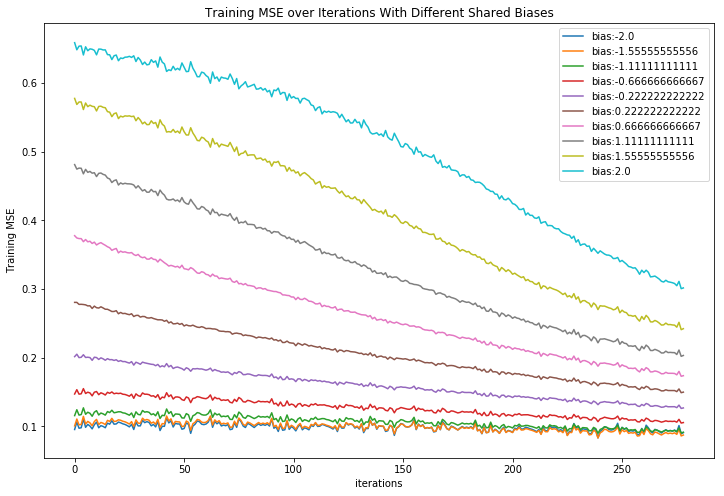

In [7]:
# create figure for plots
fig = plt.figure(figsize=(12, 8))
# run experiments and add the resulting MSE to the plot function
for bias in bias_init_search_array:
    print('for shared bias %f' %bias)
    train_mse_for_iterations, _ = run_convnet(
                                          learning_rate, 
                                          num_epochs, 
                                          train_set_x,
                                          num_filters, 
                                          batch_size, 
                                          momentum_type='sgd', 
                                          bias_type='shared', bias_init=bias)
    
    print('Training MSE after training is done: %f' 
          %train_mse_for_iterations[-1])
    plt.plot(train_mse_for_iterations, label = 'bias:'+str(bias))
plt.xlabel('iterations')
plt.ylabel('Training MSE')
plt.title('Training MSE over Iterations With Different Shared Biases')
plt.legend()    
plt.show()

Now we are testing the non-shared initialization for the bias in the output layer. You will use the same values defined previously. **Remember that, in the *run_convnet()* function of Part 1, you have to fill in the initialization line for this mode. Again, after plotting the results, add your comments to the Conclusion section** 

for non-shared 28x28 bias -2.000000
...training model...
***** Training Complete *****
Training MSE after training is done: 0.091012
for non-shared 28x28 bias -1.555556
...training model...
***** Training Complete *****
Training MSE after training is done: 0.087869
for non-shared 28x28 bias -1.111111
...training model...
***** Training Complete *****
Training MSE after training is done: 0.095194
for non-shared 28x28 bias -0.666667
...training model...
***** Training Complete *****
Training MSE after training is done: 0.119749
for non-shared 28x28 bias -0.222222
...training model...
***** Training Complete *****
Training MSE after training is done: 0.154420
for non-shared 28x28 bias 0.222222
...training model...
***** Training Complete *****
Training MSE after training is done: 0.185878
for non-shared 28x28 bias 0.666667
...training model...
***** Training Complete *****
Training MSE after training is done: 0.215657
for non-shared 28x28 bias 1.111111
...training model...
***** Training 

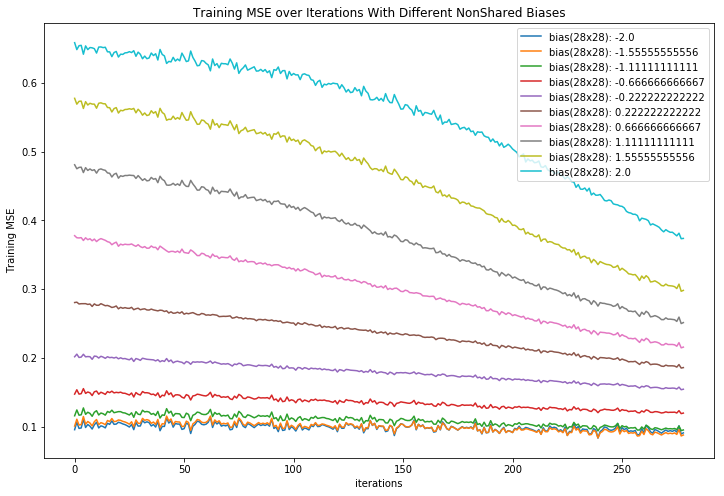

In [21]:
# create figure for plots
fig = plt.figure(figsize=(12, 8))
# run experiments and add the resulting MSE to the plot function
for bias in bias_init_search_array:
    print('for non-shared 28x28 bias %f' %bias)
    train_mse_for_iterations, _ = run_convnet(
                                            learning_rate, 
                                            num_epochs, 
                                            train_set_x,  
                                            num_filters, 
                                            batch_size, momentum_type='sgd', 
                                            bias_type='non-shared', bias_init=bias)
    
    print('Training MSE after training is done: %f' %train_mse_for_iterations[-1])
    plt.plot(train_mse_for_iterations, label = 'bias(28x28): '+str(bias))
plt.xlabel('iterations')
plt.ylabel('Training MSE')
plt.title('Training MSE over Iterations With Different NonShared Biases')
plt.legend()    
plt.show()

### 2. Parameter Update
In the second part of the assignment you will write parameter update algorithms for both momentum and Adam techniques. Please check the *gradient_update_sgd()* function, hints given below for writing your codes, as well as read section 8.3 and 8.6 of the deep learning book for more detailed information on these methods.

In [31]:
def gradient_updates_momentum(cost, params, learning_rate, momentum=0.9):
    # Function to return an update list for the parameters to be updated
    
    # Inputs:
    # cost: MSE cost Theano variable
    # params :  parameters coming from hidden and output layers
    # learning rate: learning rate defined as hyperparameter
    # momentum : momentum parameter, 
    #            usually a high value (0.8, 0.9) was chosen for momentum 
    # Outputs:
    # updates : updates to be made and to be defined in the train_model function 
    updates = []
    for param in params:
        # for each parameter, we'll create a velocity shared variable
        # since we need to remember the velocity and update in each iteration
        # it should be the same size with the param
        # we initialize it to 0
        velocity = theano.shared(param.get_value(borrow=True)*0.)

        # hint 1: remember the momentum algorithm 
        # for each parameter: 
        # compute gradient estimate 
        # compute velocity update
        # compute parameter update
        
        # hint2 : use updates.append() function similar to the 
        # gradient_updates_sgd() function above
        
       
         
        # use append function to make a list for which Theano variables will be
        # updated with which value
        vt=learning_rate * velocity - momentum*T.grad(cost, param)
        updates.append((velocity,vt))
        updates.append((param, (param + velocity)))
        
        
        return updates

In [41]:
def gradient_updates_Adam(cost, params, learning_rate):
    # Function to return an update list for the parameters to be updated
    
    # cost: MSE cost Theano variable
    # params :  parameters coming from hidden and output layers
    # learning rate: learning rate defined as hyperparameter
    
    # Outputs:
    # updates : updates to be made and to be defined in the train_model function. 
    updates = []
    eps = 1e-4 # small constant used for numerical stabilization.
    beta1 = 0.9
    beta2 = 0.999
    # beta1 and beta2 are the exponential decay rates 
    # for moment estimates, in [0,1).
    # suggested defaults: 0.9 and 0.999 respectively
    for param in params:
            # hint 1: create a shared variable for time step
            # initialize time step t = 0
            
            # hint 2: create shared variables for 1st and 2nd moment variables
            # they should be the same size with the param
            # initialize 1st and 2nd moment variables s = 0, r = 0
            
            # hint 3: the initializations of these parameters
            # will follow the same structure in momentum function 
            # (check the velocity initialization part)
            
            # hint 4: remember the Adam algorithm
            #         compute gradient
            #         update biased first moment estimate
            #         update biased second moment estimate
            #         correct bias in first moment
            #         correct bias in second moment
            #         compute parameter update
            
          
            
            g = theano.grad(cost, param)
            t = theano.shared(np.float32(1)) #innitialising t as 1 and updating it in the last
            s = theano.shared(param.get_value(borrow=True)*0.)
            r= theano.shared(param.get_value(borrow=True)*0.)
            snew = beta1*s + (1 - beta1)*g      # (Update biased first moment estimate)
            rnew = beta2*r + (1 - beta2)*g**2   # (Update biased second moment estimate)
            s_hat = s / (1-beta1**t)            # (bias-corrected first moment estimate)
            r_hat = r / (1-beta2**t)            # (bias-corrected second moment estimate)
        
            paramnew = param - (learning_rate * s_hat ) / (T.sqrt(r_hat) + eps) #(Update parameters)

            updates.append((s,snew))
            updates.append((r, rnew))
            updates.append((param, paramnew) )
            updates.append((t, t + 1.))
            
            
            
            
            
            
            
            
    return updates

Now, we will run experiments for simple gradient descent, momentum and Adam parameter update techniques.
Here, you will choose a *bias_init* value based on the results from the previous part. **Find out the best value for output bias initialization (shared version) and use the same value in the runs below.** When you run each cell, you will get a separate plot for for each method. **After getting this plot, comment on the results in Conclusion section.**

In [25]:

bias_init = -1.555556

sgd_train_mse_for_iterations, _ = run_convnet(
                                            learning_rate, 
                                            num_epochs, 
                                            train_set_x, 
                                            num_filters, 
                                            batch_size, momentum_type='sgd', 
                                            bias_type='shared', bias_init=bias_init)

print('Training MSE after training with sgd is done: %f' 
      %sgd_train_mse_for_iterations[-1])

...training model...
***** Training Complete *****
Training MSE after training with sgd is done: 0.087618


In [32]:
momentum_train_mse_for_iterations, _ = run_convnet(
                                                learning_rate, 
                                                num_epochs, 
                                                train_set_x, 
                                                num_filters, 
                                                batch_size, momentum_type='momentum', 
                                                bias_type='shared', bias_init=bias_init)

print('Training MSE after training with momentum is done: %f' 
      %momentum_train_mse_for_iterations[-1])

...training model...
***** Training Complete *****
Training MSE after training with momentum is done: 0.030597


In [42]:
adam_train_mse_for_iterations, _ = run_convnet(
                                            learning_rate, 
                                            num_epochs, 
                                            train_set_x, 
                                            num_filters, 
                                            batch_size, momentum_type='Adam', 
                                            bias_type='shared', bias_init=bias_init)

print('Training MSE after training with Adam is done: %f' 
      %adam_train_mse_for_iterations[-1])

...training model...
***** Training Complete *****
Training MSE after training with Adam is done: 0.007415


The section below is for plotting the loss values during the training with different parameter update techniques. There will be no change for this cell.

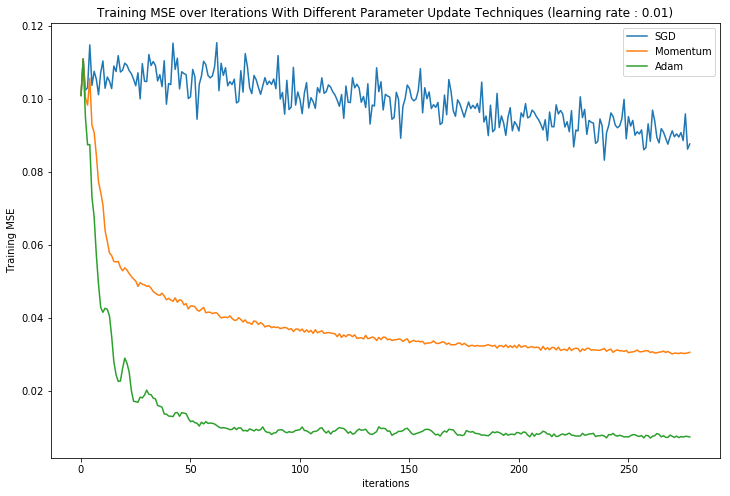

In [43]:
fig = plt.figure(figsize=(12, 8))
plt.plot(sgd_train_mse_for_iterations, label = 'SGD')
plt.plot(momentum_train_mse_for_iterations, label = 'Momentum')
plt.plot(adam_train_mse_for_iterations, label = 'Adam')
plt.xlabel('iterations')
plt.ylabel('Training MSE')
plt.title('Training MSE over Iterations With Different Parameter Update Techniques (learning rate : 0.01)')
plt.legend()    
plt.show()

Now you will repeat the experiments with different learning rates = 0.1 and 0.001. After getting the results from parameter update techniques used with different learning rates, report the best model out of these nine models.

for learning rate 0.100000:
...training model...
***** Training Complete *****
Training MSE after training with sgd is done: 0.013685
...training model...
***** Training Complete *****
Training MSE after training with momentum is done: 0.030359
...training model...
***** Training Complete *****
Training MSE after training with Adam is done: 0.013503


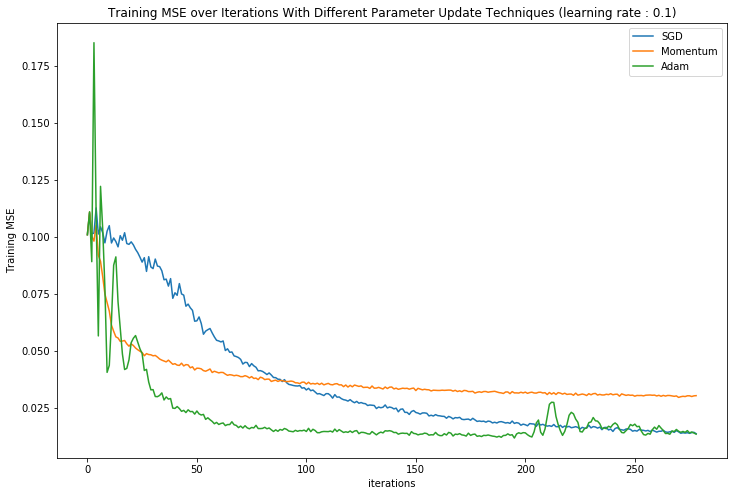

In [44]:
learning_rate = 0.1
print('for learning rate %f:' %(learning_rate))
sgd_train_mse_for_iterations, _ = run_convnet(
                                            learning_rate, 
                                            num_epochs, 
                                            train_set_x, 
                                            num_filters, 
                                            batch_size, momentum_type='sgd', 
                                            bias_type='shared', bias_init=bias_init)

print('Training MSE after training with sgd is done: %f' 
      %sgd_train_mse_for_iterations[-1])

momentum_train_mse_for_iterations, _ = run_convnet(
                                                learning_rate, 
                                                num_epochs, 
                                                train_set_x, 
                                                num_filters, 
                                                batch_size, momentum_type='momentum', 
                                                bias_type='shared', bias_init=bias_init)

print('Training MSE after training with momentum is done: %f' 
      %momentum_train_mse_for_iterations[-1])

adam_train_mse_for_iterations, _ = run_convnet(
                                            learning_rate, 
                                            num_epochs, 
                                            train_set_x, 
                                            num_filters, 
                                            batch_size, momentum_type='Adam', 
                                            bias_type='shared', bias_init=bias_init)

print('Training MSE after training with Adam is done: %f' 
      %adam_train_mse_for_iterations[-1])
fig = plt.figure(figsize=(12, 8))
plt.plot(sgd_train_mse_for_iterations, label = 'SGD')
plt.plot(momentum_train_mse_for_iterations, label = 'Momentum')
plt.plot(adam_train_mse_for_iterations, label = 'Adam')
plt.xlabel('iterations')
plt.ylabel('Training MSE')
plt.title('Training MSE over Iterations With Different Parameter Update Techniques (learning rate : 0.1)')
plt.legend()    
plt.show()

for learning rate 0.001000:
...training model...
***** Training Complete *****
Training MSE after training with sgd is done: 0.105633
...training model...
***** Training Complete *****
Training MSE after training with momentum is done: 0.030685
...training model...
***** Training Complete *****
Training MSE after training with Adam is done: 0.010572


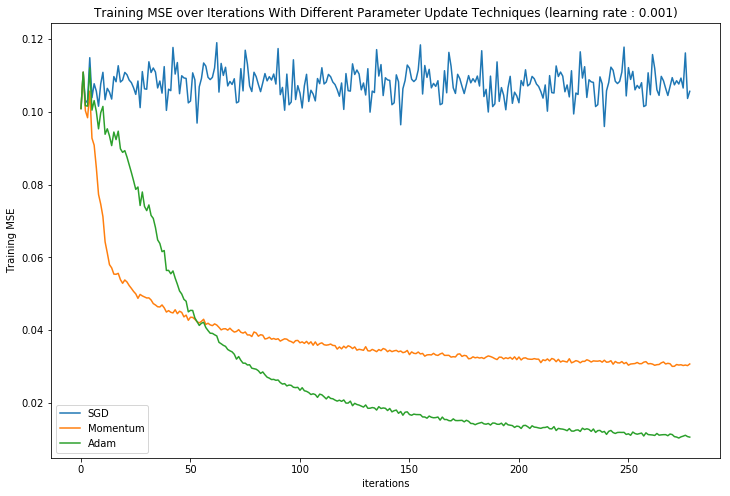

In [45]:
learning_rate = 0.001
print('for learning rate %f:' %(learning_rate))
sgd_train_mse_for_iterations, _ = run_convnet(
                                            learning_rate, 
                                            num_epochs, 
                                            train_set_x, 
                                            num_filters, 
                                            batch_size, momentum_type='sgd', 
                                            bias_type='shared', bias_init=bias_init)

print('Training MSE after training with sgd is done: %f' 
      %sgd_train_mse_for_iterations[-1])

momentum_train_mse_for_iterations, _ = run_convnet(
                                                learning_rate, 
                                                num_epochs, 
                                                train_set_x, 
                                                num_filters, 
                                                batch_size, momentum_type='momentum', 
                                                bias_type='shared', bias_init=bias_init)

print('Training MSE after training with momentum is done: %f' 
      %momentum_train_mse_for_iterations[-1])

adam_train_mse_for_iterations, _ = run_convnet(
                                            learning_rate, 
                                            num_epochs, 
                                            train_set_x, 
                                            num_filters, 
                                            batch_size, momentum_type='Adam', 
                                            bias_type='shared', bias_init=bias_init)

print('Training MSE after training with Adam is done: %f' 
      %adam_train_mse_for_iterations[-1])

fig = plt.figure(figsize=(12, 8))
plt.plot(sgd_train_mse_for_iterations, label = 'SGD')
plt.plot(momentum_train_mse_for_iterations, label = 'Momentum')
plt.plot(adam_train_mse_for_iterations, label = 'Adam')
plt.xlabel('iterations')
plt.ylabel('Training MSE')
plt.title('Training MSE over Iterations With Different Parameter Update Techniques (learning rate : 0.001)')
plt.legend()    
plt.show()

Finally, select the best model giving the minimum MSE by looking the parameter update technique and the learning rate, then run the code snippet below by inserting the parameters for your best model in order to see the predicted images from their binarized versions.

...training model...
***** Training Complete *****


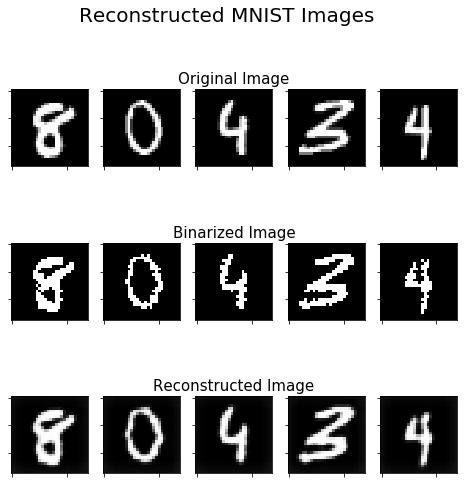

In [46]:
################# Insert Your Code Here ###################
learning_rate = 0.01
momentum_type_string = 'Adam'
################# Insert Your Code Here ###################
_, [original_input, binarized_input, predicted_output] = run_convnet(
                                    learning_rate, 
                                    num_epochs, 
                                    train_set_x, 
                                    num_filters, 
                                    batch_size, momentum_type=momentum_type_string, 
                                    bias_type='shared', bias_init=bias_init)

# four axes, returned as a 2-d array
f, axarr = plt.subplots(3, 5, figsize=(8, 8))
for i in range(5):
    axarr[0,i].imshow(
        original_input[i].reshape(28,28).astype('float32'), cmap='gray')
    axarr[1,i].imshow(
        binarized_input[i].reshape(28,28).astype('float32'), cmap='gray')
    axarr[2,i].imshow(
        predicted_output[i].reshape(28,28).astype('float32'), cmap='gray')
    # Turn off tick labels
    axarr[0,i].set_yticklabels([])
    axarr[0,i].set_xticklabels([])
    axarr[1,i].set_yticklabels([])
    axarr[1,i].set_xticklabels([])
    axarr[2,i].set_yticklabels([])
    axarr[2,i].set_xticklabels([])
axarr[0,2].set_title('Original Image', fontsize=15)
axarr[1,2].set_title('Binarized Image', fontsize=15)
axarr[2,2].set_title('Reconstructed Image', fontsize=15)
plt.suptitle('Reconstructed MNIST Images', fontsize=20)
plt.show()

### Conclusions

Part 1-

1. For the shared bias initialization MSE is minimum(0.087) with shared bias initial value of (-1.556). With the increase of bias more than that the MSE started to increase again.

2. Similiar as in 1, the MSE is minimum(0.088) with non-shared bias initial value of (-1.556). Obviously non-shared biases means more parameters and potentially more flexibility but also more overfitting risk 

Part2-

1. for learning rate=0.01 Adam performs best and gets to low MSE rapidly. SGD performs poor, may need a lot more iterations. Momentum performs in between SGD and Adam.

MSE_SGD=0.0876
MSE_Momentum=0.0305
MSE_Adam=0.0074

2. for learning rate=0.1, SGD and Adam both perform well and gave similiar results. SGD graph is even smoother than Adam. 

MSE_SGD=0.0137
MSE_Momentum=0.0303
MSE_Adam=0.0135

3. for learning rate=0.001, SGD performs very poor, its error even increased, as it is obvious that higher learning rate destabilises SGD. MSE for Momentum is still almost same.Momentum error goes down very fast but the end result is not as good as Adam's. Adam performed best. 

MSE_SGD=0.0137
MSE_Momentum=0.0303
MSE_Adam=0.0106

Conclusion:

Overall,  Adam at the learning rate of 0.01 is the clear winner. The SGD needs to be assigned adequate learning rate or it can go wrong, with correct learning rate it may perform as well as Adam.

